# One-Factor Hull-White Model with US Treasury Yield Curves

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("vlag"))

### use US Treasury yield curve as spot rates and acquire data from FRED 

In [2]:
# load api key from a local .env file
import os
from dotenv import load_dotenv
load_dotenv()

from fredapi import Fred
# documentation: https://pypi.org/project/fredapi/

fred = Fred(api_key=os.getenv('fred_key'))

fred.search("GS1M").title.iloc[0]

'Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis'

In [3]:
def get_spot_curve(sample_start: str = "1/1/2023") -> pd.DataFrame:
    """obtain the US Treasury yield curves from FRED with monthly frequency.

    Args:
        sample_start (str, optional): start date of the sample. Defaults to "1/1/2023".

    Returns:
        pd.DataFrame: yield curves, terms are presented in months
    """
    t_dict = {
        "GS1M": (1 / 12),  # 1 month
        "GS6M": 0.5,  # 6 month
        "GS1": 1,  # 1 year
        "GS2": 2,
        "GS3": 3,
        "GS5": 5,  # 5 year
        "GS7": 7,
        "GS10": 10,  # 10 year
    }

    t_mkt_yld = pd.DataFrame()
    for key in t_dict:
        _m = (
            fred.get_series(key, observation_start=sample_start).to_frame(
                t_dict[key] * 12
            )
            / 100
        )
        t_mkt_yld = t_mkt_yld.merge(_m, left_index=True, right_index=True, how="outer")

    t_mkt_yld = t_mkt_yld.reindex(sorted(t_mkt_yld.columns), axis=1)
    t_mkt_yld.index += pd.offsets.MonthEnd(0)

    return t_mkt_yld


t_mkt_yld = get_spot_curve()
t_mkt_yld.tail()

,1.0,6.0,12.0,24.0,36.0,60.0,84.0,120.0
2024-02-29,0.0549,0.0528,0.0492,0.0454,0.0433,0.0419,0.0421,0.0421
2024-03-31,0.0551,0.0536,0.0499,0.0459,0.0438,0.0420,0.0421,0.0421
2024-04-30,0.0548,0.0538,0.0514,0.0487,0.0471,0.0456,0.0456,0.0454
2024-05-31,0.0550,0.0542,0.0516,0.0486,0.0466,0.0450,0.0449,0.0448
2024-06-30,0.0546,0.0537,0.0511,0.0474,0.0450,0.0432,0.0430,0.0431


### cubic spline interpolation

In [4]:
from scipy.interpolate import CubicSpline

monthly_spot_rate = pd.DataFrame(columns=range(1, 121))
for _index, _row in t_mkt_yld.iterrows():
    _cs = CubicSpline(_row.index, _row)
    monthly_spot_rate.loc[_index] = _cs(range(1, 121))

monthly_spot_rate.tail()


,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
2024-02-29,0.0549,0.054646,0.054294,0.053859,0.053356,0.0528,0.052206,0.051590,0.050966,0.050350,...,0.042301,0.042288,0.042273,0.042256,0.042237,0.042214,0.042190,0.042163,0.042133,0.0421
2024-03-31,0.0551,0.055049,0.054854,0.054534,0.054109,0.0536,0.053027,0.052409,0.051767,0.051122,...,0.042364,0.042348,0.042329,0.042306,0.042281,0.042252,0.042219,0.042183,0.042144,0.0421
2024-04-30,0.0548,0.054757,0.054623,0.054410,0.054132,0.0538,0.053428,0.053027,0.052612,0.052193,...,0.045682,0.045662,0.045640,0.045614,0.045586,0.045555,0.045521,0.045484,0.045444,0.0454
2024-05-31,0.0550,0.055045,0.054972,0.054796,0.054533,0.0542,0.053812,0.053384,0.052933,0.052475,...,0.044951,0.044941,0.044929,0.044916,0.044901,0.044884,0.044866,0.044846,0.044824,0.0448
2024-06-30,0.0546,0.054599,0.054495,0.054302,0.054033,0.0537,0.053317,0.052896,0.052451,0.051995,...,0.043131,0.043132,0.043131,0.043130,0.043127,0.043124,0.043120,0.043114,0.043108,0.0431


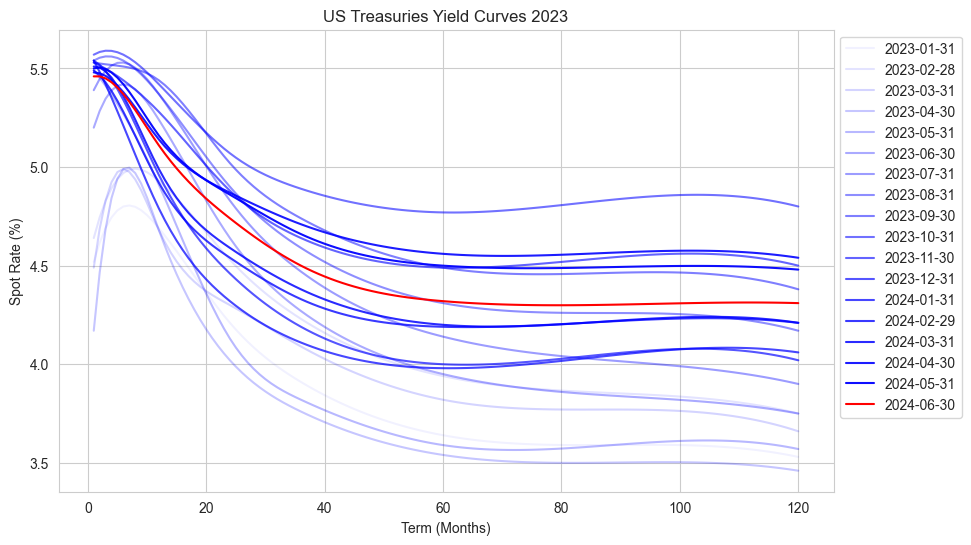

In [5]:
fig_term_structure, ax = plt.subplots(figsize=(10, 6))
for _i, (_index, _row) in enumerate(monthly_spot_rate.iterrows()):
    if _index == monthly_spot_rate.index.max():
        color = "red"
    else:
        color = "blue"
    ax.plot(
        _row.index,
        _row.values * 100,
        color=color,
        alpha=(_i + 1) / len(monthly_spot_rate),  # latest date has the deepest color
        label=_index.date(),
    )


ax.set_title("US Treasuries Yield Curves 2023")
ax.set_xlabel("Term (Months)")
ax.set_ylabel("Spot Rate (%)")
ax.legend(loc="best", bbox_to_anchor=(1, 1))

it can be seen the yield curves are inverted for all 12 months in 2023.

the market's expectation of the interest rates in long term fluctuates between 3.5% and 5%.

### as an extension of the Vasicek model, the Hull-White one-factor model introduces a time-varying parameter 

One-factor refers to only one source of uncertainty is assumed for the interest rate dynamics. 

The Vasicek $\theta$ is chosen to be epxressed as a deterministic function of the given market term structure of rates:

$$
dr(t)=(\theta(t)-k r(t))dt +\sigma dW(t)
$$

here, $k$ and $\sigma$ are positive constant. $dW(t)$ represents a Wiener process. It implies a normal distribution for the short-rate process at each time.

The term $\theta(t)-k r(t)$ has a mean reversion property. Whenever the short rate is above the long-term level, the drift term of the stochastic process is negative, and when it is below that level
the drift is positive. Historical evidence shows such a trend for the interest rate.

$\sigma$ is the standard deviation of rate of change in short rate, i.e. the standard deviation of $dr(t)/r(t)$.

We will see how this model can incorporate different yield curve shapes, such as the highly inverted curve today, in the later section. 

### calculate instantaneous forward curves

$$
f(0, t)\cong r(0, t+\Delta t) + t \frac{r(0, t+\Delta t)-r(0, t)}{\Delta t}
$$

for simplicity's sake, here $\Delta t$ is set to be one month, i.e., $\Delta t = 1 / 12$

In [6]:
def get_inst_fr(spot_curve: pd.Series, delta_t: float = 1 / 12) -> pd.Series:

    # be careful when delta_t is used as the index to retrieve data from a series indexed by month,
    # np.round(delta_t * 12) is used to make sure it would be a integer
    instantaneous_fr = pd.Series()
    instantaneous_fr.loc[0] = spot_curve[1]
    for _m in range(1, len(spot_curve) - 1):
        instantaneous_fr.loc[_m] = (
            spot_curve[_m + np.round(delta_t * 12)]
            + (_m / 12)
            * (spot_curve[_m + np.round(delta_t * 12)] - spot_curve[_m])
            / delta_t
        )
    return instantaneous_fr


# the spot curve on 2024-1-31 is used here
spot_curve = monthly_spot_rate.loc["2024-1-31"]
instantaneous_fr = get_inst_fr(spot_curve, delta_t=1 / 12)

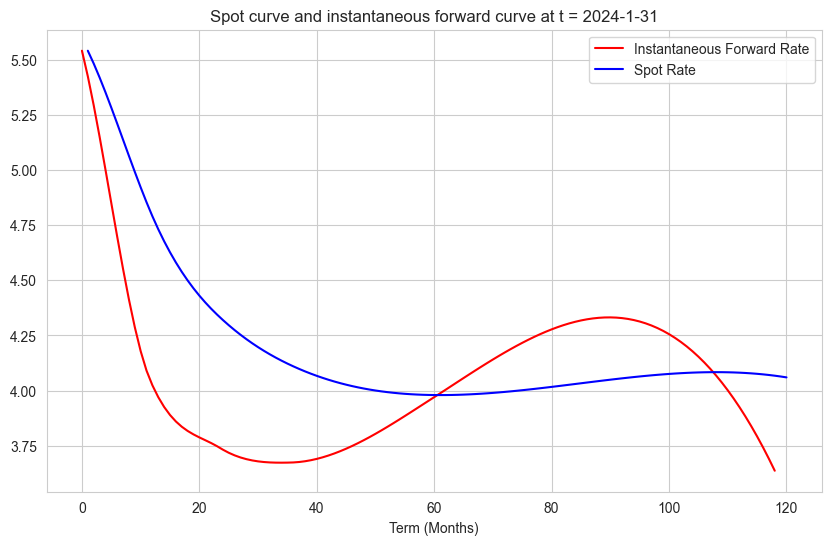

In [7]:
fig_spot_ins_fr, ax = plt.subplots(figsize=(10, 6))
ax.plot(instantaneous_fr*100, color="red", label="Instantaneous Forward Rate")
ax.plot(spot_curve*100, color="blue", label="Spot Rate")
ax.set_title("Spot curve and instantaneous forward curve at t = 2024-1-31")
ax.set_xlabel("Term (Months)")
ax.legend()


### calibration of the parameters $k$ and $\sigma$

The two constant parameters of the model are obtained from historical data using an estimation method, such as a maximum likelihood estimation. 

In [8]:
# for now assume k= and sigma=
k = 0.5
sigma = 0.005

### calculate the approximate value for $\theta(t)$

As described before, $\theta (t)$ is used to fit the initial term structure observed in the market. It defines the average slope at time t. 

The approximate discretized $\theta (t)$ can be calculated as follows (Brigo and Mercurio 2001):

$$
\theta (t) \cong \frac{f(0, t+\Delta t)-f(0, t)}{\Delta t} + kf(0, t) + \frac{\sigma^2}{2k}(1-e^{-2kt})
$$

In [9]:
def get_theta(
    instantaneous_fr: pd.Series,
    k: float,
    sigma: float,
    delta_t: float = 1 / 12,
) -> pd.Series:
    """calculate theta given the pravailing instantaneous forward curve.

    Args:
        instantaneous_fr (pd.Series): the pravailing instantaneous forward rate.
        k (float): speed of mean reversion
        sigma (float): the standard deviation of rate of change in short rate
        delta_t (float, optional): simulation intervals in years. Defaults to 1/12.

    Returns:
        pd.Series: the average direction in which r moves
    """

    theta_t = pd.Series()
    for _t in range(1, len(instantaneous_fr) - 1):
        theta_t.loc[_t] = (
            (instantaneous_fr[_t + np.round(delta_t * 12)] - instantaneous_fr[_t]) / delta_t
            + k * instantaneous_fr[_t]
            + (sigma**2 / (2 * k)) * (1 - np.exp(-2 * k * _t / 12))
        )

    return theta_t


theta_t = get_theta(instantaneous_fr=instantaneous_fr, k=k, sigma=sigma)

### calculate the short rate r(t)

the approximate discretized version of the HW model:
$$
\Delta r(t) = (\theta (t) - k r(s)) \Delta t + \sigma \sqrt{\Delta t} \epsilon
$$
hence, $r(t) = r(s)+\Delta r(t)$ given $r(s)$, the short rate at any time $s < t$, and for $\Delta t = t − s$

In each step, $\epsilon$ is an independent instance from the standard normal distribution.

In [10]:
def get_short_rate(
    spot_curve: pd.Series,
    theta_t: pd.Series,
    k: float,
    sigma: float,
    delta_t: float = 1 / 12,
) -> pd.Series:
    """this function derive the simulated short rate path with Hull-White Model given theta(t), k and sigma.

    Args:
        spot_curve (pd.Series): the observed spot yield curve
        theta_t (pd.Series): the average direction in which r moves, derived from today's zero coupon yield curve
        k (float): speed of mean reversion
        sigma (float): the standard deviation of rate of change in short rate
        delta_t (float, optional): simulation intervals in years. Defaults to 1/12.

    Returns:
        pd.Series: simulated short rate path.
    """

    short_rate = pd.Series()
    # assume r(0) equals to the current spot rate with the shortest term, i.e., one month
    short_rate.loc[0] = spot_curve.iloc[0]

    epsilon = np.random.normal(scale=1, size=len(theta_t) - 1)

    for _t in range(1, len(theta_t) - 1):
        short_rate.loc[_t] = (
            short_rate.loc[_t - np.round(delta_t * 12)]
            + (theta_t.loc[_t] - k * short_rate.loc[_t - np.round(delta_t * 12)])
            * delta_t
            + sigma * np.sqrt(delta_t) * epsilon[_t - 1]
        )

    return short_rate

In [11]:
def hw(spot_curve:pd.Series, n:int=1, k:float=k, sigma:float=sigma, seed:int = 123) -> tuple:
    """Hull-White model

    Args:
        spot_curve (pd.Series): yield curve
        n (int, optional): number of short rate paths to generate. Defaults to 1.
        k (float): speed of mean reversion
        sigma (float): the standard deviation of rate of change in short rate
        seed (int, optional): seed. Defaults to 123.

    Returns:
        tuple: instantanous forward rates, theta(t) and short rate paths in order
    """
    instantaneous_fr = get_inst_fr(spot_curve, delta_t=1 / 12)
    theta_t = get_theta(instantaneous_fr=instantaneous_fr, k=k, sigma=sigma)

    np.random.seed(seed=seed)

    short_rate_path = pd.DataFrame()
    _p = 0
    while _p < n:
        short_rate_path = pd.merge(short_rate_path,
                                    get_short_rate(spot_curve, theta_t, k=k, sigma=sigma).rename(_p),
                                    left_index=True, 
                                    right_index=True,
                                    how="outer").sort_index(axis=1)
        _p += 1


    return (
            instantaneous_fr,
            theta_t,
            short_rate_path,
        )
    

Text(0.5, 0, 'Time (Months)')

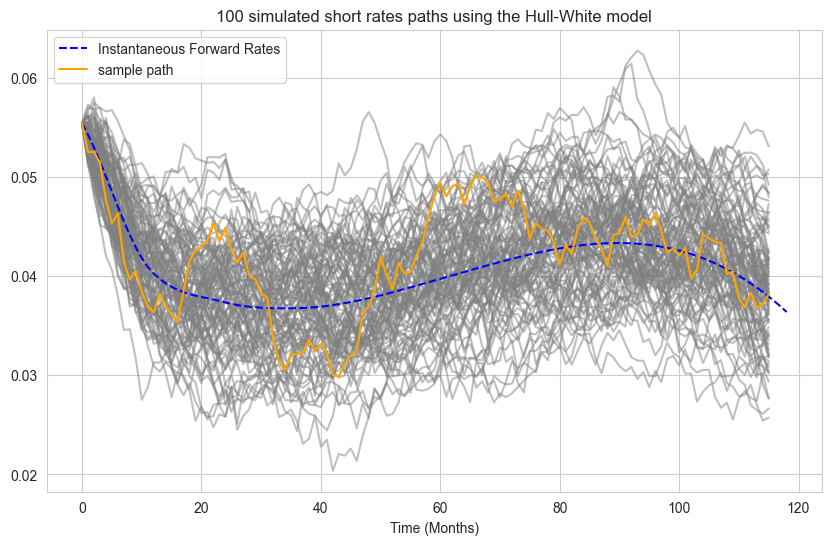

In [12]:
# _, _, short_rate_1 = hw(spot_curve)

fig_simulated_paths, ax = plt.subplots(figsize=(10, 6))

ax.plot(hw(spot_curve, n=100)[2], color="gray", alpha=0.5)

ax.plot(
    instantaneous_fr,
    linestyle="dashed",
    color="b",
    label="Instantaneous Forward Rates",
)
ax.plot(hw(spot_curve)[2], label="sample path", color="orange")


ax.legend(loc="best")
ax.set_title("100 simulated short rates paths using the Hull-White model")
ax.set_xlabel("Time (Months)")

with the "noise" effect, $\epsilon$, short rates in the Hull-White model can become negative. 

if the modeled rate is expected to be always positive, the output of the Hull-White model is floored at zero.

### pricing zero-coupon bond with time-dependent deterministic short rates

the price of a zero-coupon bond has the following affine term structure model (Brigo and Mercurio 2001):

$$
P(t, T) = A(t, T)e^{-B(t, T)r(t)}
$$

and the expressions for $A(t, T)$ and $B(t, T)$ are:

$$
A(t, T) = \frac{P(0, T)}{P(0, t)} \text{exp}[B(t, T)f(0, t)-\frac{\sigma^2}{4k}(1-e^{-2kt})B(t, T)^2]
$$

$$
B(t, T) = \frac{1-e^{-k(T-t)}}{k}
$$

where $f(0, t)$ is the prevailing instantaneous forward rate as of $t$ years and $r(t)$ is the short rate.

In [13]:
_, _, short_rates = hw(spot_curve, n=3)
short_rates.loc[1].mean()

0.0527417694505957

In [14]:
def price_zero_coupon_bond(
    spot_curve: pd.Series,
    maturity_date: int,
    t: int = 0,
    face_value: float = 100,
    k: float = k,
    sigma: float = sigma,
    n_path: int = 1,
    seed: int = 123,
) -> float:
    """this function calculate the value of a zero coupon bond at time t.

    Args:
        spot_curve (pd.Series): spot rates (treasury yields)
        maturity_date (int): the term when the bond matures (in month), T.
        t (int, optional): the time when the bond is valuated in month. Defaults to 0.
        face_value (float, optional): face value of the bond. Defaults to 100.
        k (float): for simplicity treated as a constant, defined in calibration section
        sigma (float): the standard deviation of rate of change in short rate, defined in calibration section
        n_path (int): the number of short rate paths from hw() used to price bonds
        seed (int): random seed. Defaults to 123.

    Raises:
        ValueError: _description_
        ValueError: _description_

    Returns:
        float: value of the zero-coupon bond at time t
    """

    instantaneous_fr, _, short_rates = hw(spot_curve, n=n_path, seed=seed)

    T = maturity_date
    if T > 117:
        raise ValueError("Maturity exceeds short rate limits. ")
    if T < t:
        raise ValueError("Maturity must be positive.")

    if t == 0:
        P_t_T = face_value * np.exp(-spot_curve.loc[T] * T / 12)
    else:
        P_0_t = np.exp(-spot_curve.loc[t] * (t / 12))
        P_0_T = np.exp(-spot_curve.loc[T] * (T / 12))
        B_t_T = (1 - np.exp(-k * (T - t))) / k
        A_t_T = (P_0_T / P_0_t) * np.exp(
            B_t_T * instantaneous_fr.loc[t]
            - sigma**2 / (4 * k) * (1 - np.exp(-2 * k * (t / 12))) * B_t_T**2
        )

        P_t_T = face_value * A_t_T * np.exp(-B_t_T * short_rates.loc[t].mean())

    return P_t_T


print(
    "The value of a zero-coupon bond with 5 year maturity in 1 year is: {:0.6f}".format(
        price_zero_coupon_bond(spot_curve, maturity_date=72, t=12, n_path=1)
    )
)

The value of a zero-coupon bond with 5 year maturity in 1 year is: 83.192779


In [15]:
print("The present value of a zero-coupon bond with 5 year maturity is: {:0.6f}".format(price_zero_coupon_bond(spot_curve, maturity_date=60, t=0)))

The present value of a zero-coupon bond with 5 year maturity is: 81.954989


since the yield curve is inverted. the value of a bond with the same time to maturity increases from 81.95 to 83.19 in one year, keep everything else constant. 



for a quick sensation check:

given the spot yield curve from FRED, we have today's spot rates $r(12)=0.0479$ and $r(72)=0.0399$.

define the 5-year forward rate in 1 year as $r(12, 72)$.

according to arbitrage-free theory: $(1+r(72))^6=(1+r(12))^1(1+r(12, 72))^5$

the 5-year forward rate in 1 year is hence 0.03835 by solving the equation.

the price of a zero-coupon bond with 5-year maturity in 1 year would be: $P(12, 72)=100\times (1+r(12, 72)^{-5}) = 82.84$, compared to the result of 83.19 using short rates from HW model.

### Pricing bonds with fixed coupon payments

consider a fixed-rate coupon bond with coupon payments $c_1, c_2, ... c_n$ at times $T_1, T_2, ... T_n \in (t, T] $, the present value of this bond on at time $t$ is the linear combination of the present value of all of its coupon payments and its principal payment when it matures. each coupon payment can be considered as a repayment of zero-coupon bond at each time $t$.

In [16]:
def get_coupon_dates(
    t: int, 
    next_payment: int, 
    maturity_date: int, 
    coupon_interval: int
) -> list:
    """the function return the sequence of coupon payment date, [T1, T2, ... Tn] in month

    Args:
        t (int): valuation date
        next_payment_to_t (int): the number of months of the next coupon payment from t
        maturity_date (int): the term when the bond matures (in month), T.
        coupon_interval (int): 6 months or 12 months

    Returns:
        list: _description_
    """
    
    if next_payment < t:
        raise ValueError("The first coupon payment is earlier than the valuation date, i.e. next_payment < t.")

    c_payment_date = []

    # next_payment_to_t += t
    while next_payment <= maturity_date:
        c_payment_date.append(next_payment)
        next_payment += coupon_interval
    return c_payment_date


get_coupon_dates(t=1, next_payment=1, maturity_date=61, coupon_interval=6)

[1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61]

In [17]:
def get_fixed_rate_bond_price(
    spot_curve: pd.Series,
    maturity_date: int,
    coupon_rate: float,
    next_payment: int,
    payment_frq: str = "semi",
    t: int = 0,
    face_value: float = 100,
    k: float = k,
    sigma: float = sigma,
    n_path: int = 1,
    seed: int = 123,
) -> float:
    """calculate the valuation of a fixed rate bond with simulated short rate

    Args:
        spot_curve (pd.Series): _description_
        time_to_maturity (int): in months
        maturity_date (int): the term when the bond matures (in month), T.
        coupon_rate (float): in percentage
        next_payment (int): next coupon payment date in months
        payment_frq (str, optional): "semi" or "annual". Defaults to "semi".
        t (int, optional): in months. Defaults to 0.
        face_value (float, optional): Defaults to 100.
        k (float, optional): Defaults to k.
        sigma (float, optional): the standard deviation of rate of change in short rate. Defaults to sigma.
        n_path (int): the number of short rate paths from hw() used to price bonds
        seed (int): random seed. Defaults to 123.

    Raises:
        ValueError: _description_
        ValueError: _description_

    Returns:
        float: _description_
    """

    if payment_frq not in ["annual", "semi"]:
        raise ValueError(
            payment_frq
            + " is not a valid value for payment_frq; supported values are 'annual' and 'semi'."
        )

    coupon_interval = {"annual": 12, "semi": 6}[payment_frq]
    # check if the last coupon payment happens at the same time as the principle payment:
    if (
        maturity_date - next_payment
    ) % coupon_interval == 0 or maturity_date == next_payment:
        pass
    else:
        raise ValueError(
            "The last coupon payment does not happen at the same time as the principal payment."
        )

    # principal value at t
    principal_value_t = price_zero_coupon_bond(
        spot_curve,
        maturity_date=maturity_date,
        t=t,
        face_value=face_value,
        k=k,
        sigma=sigma,
        n_path=n_path,
        seed=seed,
    )

    if coupon_rate == 0:
        return principal_value_t

    # if the coupon is paid semi-annually, each payment will be half of the bond's annual coupon rate.
    coupon = (coupon_rate * face_value / 100) * (coupon_interval / 12)

    coupon_payment_date = get_coupon_dates(
        t, next_payment, maturity_date, coupon_interval
    )
    # print("Coupon payments will be made at times:")
    # print(*coupon_payment_date)

    total_coupon_value_t = 0

    for _c in coupon_payment_date:
        # consider each coupon payment as a zero-coupon bond
        this_coupon_v_t = price_zero_coupon_bond(
            spot_curve,
            maturity_date=_c,
            t=t,
            face_value=coupon,
            k=k,
            sigma=sigma,
            n_path=n_path,
            seed=seed,
        )
        total_coupon_value_t += this_coupon_v_t
        # print("the value of the coupon paid at time " + str(_c) + " is " + str(round(this_coupon_v_t, 6)) + " at time " + str(t))

    total_value = total_coupon_value_t + principal_value_t
    # print("The value of this fixed-rate bond is " + str(round(total_value, 4)) + " at time " + str(t))
    return total_value


get_fixed_rate_bond_price(
    spot_curve, next_payment=1, maturity_date=13, coupon_rate=1, payment_frq="annual"
)

96.94922122091464

for example, consider a 10s conpon bond which matures in 6 months from now, i.e. $T=6, c=10$. it has one last coupon at its mature date. 

to calculate its value at time $t=1$:  

In [18]:
get_fixed_rate_bond_price(
    spot_curve,
    next_payment=6,
    maturity_date=6,
    coupon_rate=10,
    t=1,
    payment_frq="annual",
)

108.01658257908275

In [19]:
print("The value of the last coupon at time t=1 is ")
print(price_zero_coupon_bond(spot_curve, maturity_date=6, t=1, face_value=10))

print(
    "The sum of the value of the last coupon and its principal payment at time t=1 is "
)
print(
    price_zero_coupon_bond(spot_curve, maturity_date=6, t=1)
    + price_zero_coupon_bond(spot_curve, maturity_date=6, t=1, face_value=10)
)

The value of the last coupon at time t=1 is 
9.81968932537116
The sum of the value of the last coupon and its principal payment at time t=1 is 
108.01658257908275


### Net Present Value

net present value is defined as the present value of the future cash flow minus the initial investment.

assume we receive a bond (future) price quote today with a forward date $t$ and matures at $T$. We can calculate the economic value of this future bond with the above modelling process and compare with the cost of the contract.

if the economic value of the future bond is higher than the cost of the contract, the NPV of this transaction will be positive. 

In an efficient market, valuation models should produce economic values that are equal or very close to the market values and NPV is expected to be zero.

consider two treasury bonds both mature on 1/31/2029, which is five year from now, the bonds pay 1.75 and 4.00 coupons. Their market quotes on Feb 2 2024 are shown below.

<img src="treasury quotes 20240202.jpg" alt="Drawing" style="width: 1000px;"/>


source: https://www.wsj.com/market-data/bonds/treasuries

In [20]:
for _b in [1.75, 4]:
    print(
        "The present value of the {:.2f}s bond is {:.4f}.".format(
            _b,
            get_fixed_rate_bond_price(
                spot_curve, maturity_date=60, coupon_rate=_b, next_payment=6,
            ),
        )
    )

The present value of the 1.75s bond is 89.7765.
The present value of the 4.00s bond is 99.8327.


compared to their market (ask) quotes, the 1.75s bond can be considered *cheap* by 0.4865, while the 4.00s bond can be considered *rich* by 0.1773.

In an ideal market without transaction costs, this could be an arbitrage opportunity. 

## scenario analysis - Duration

### parallel shocks
Rates at all term points of the current yield curve are shocked by:

$$
\Delta r_{parallel,c}(t)=\pm \hat{r}_{parallel,c}
$$

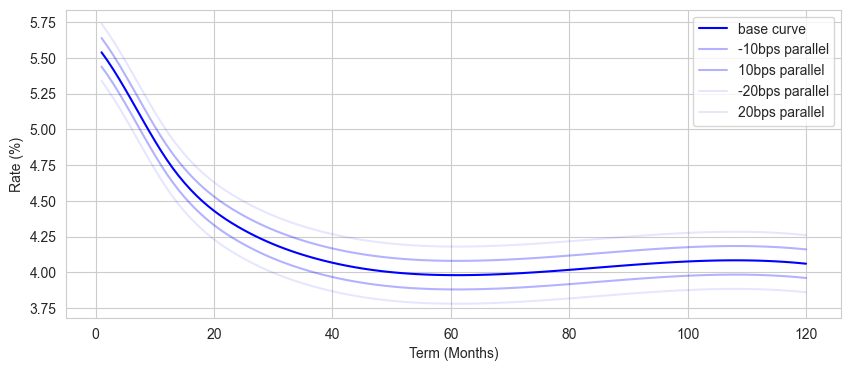

In [25]:
scenarios = pd.DataFrame(spot_curve.rename(0))

for _bp in range(0, 11):
    scenarios[_bp] = scenarios[0] + _bp/10**4
    scenarios[-_bp] = scenarios[0] - _bp/10**4

for _bp in range(0, 201, 10):
    scenarios[_bp] = scenarios[0] + _bp/10**4
    scenarios[-_bp] = scenarios[0] - _bp/10**4

for _bp in [151, 149]:
    scenarios[_bp] = scenarios[0] + _bp/10**4
    scenarios[-_bp] = scenarios[0] - _bp/10**4

fig_shocks, ax = plt.subplots(figsize=(10, 4))

ax.plot(scenarios[0]*100, color="b", alpha=1, label="base curve")

for _s in [10, 20]:
    for _d in [-1, 1]:
        ax.plot(scenarios[_s*_d]*100, color="b", label="{:d}bps parallel".format(_s*_d), alpha=1-(_s+25)/50)

ax.set_xlabel("Term (Months)")
ax.set_ylabel("Rate (%)")

ax.legend(loc="best")

recall two bonds, 1.75s of 01/31/2029 and 4s of 01/31/2029 from above.

we now reprice these bonds in all scenarios

In [27]:
shocked_prices_175 = pd.Series()
shocked_prices_400 = pd.Series()

for _s in scenarios.columns:
    _spot_curve = scenarios[_s]
    shocked_prices_175.loc[_s] = get_fixed_rate_bond_price(
        _spot_curve, maturity_date=60, coupon_rate=1.75, next_payment=6
    )
    shocked_prices_400.loc[_s] = get_fixed_rate_bond_price(
        _spot_curve, maturity_date=60, coupon_rate=4, next_payment=6
    )


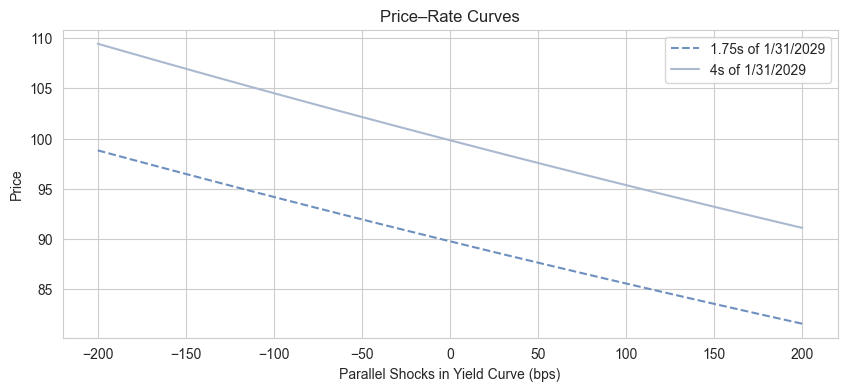

In [26]:
# shocked_prices.sort_index().plot()

fig_price_rate_curve, ax = plt.subplots(figsize=(10, 4))
ax.plot(shocked_prices_175.sort_index(), label="1.75s of 1/31/2029", linestyle='dashed')
ax.plot(shocked_prices_400.sort_index(), label="4s of 1/31/2029")

ax.set_xlabel("Parallel Shocks in Yield Curve (bps)")
ax.set_ylabel("Price")
ax.set_title("Price–Rate Curves")
ax.legend()

In [32]:
for _s in [-1, 1]:
    print("With {:d}bp parallel shock, the price of 1.75s is {:0.4f}.".format(_s, shocked_prices_175.loc[_s]))

def duration(l, h):
    return (-1 / h) * (h - l) / 0.0002

for _b, _p in zip(["1.75", "4"],
                  [shocked_prices_175, shocked_prices_400],
                  ):
    print("The duation of {:s}s of 1/31/2029 is {:.2f} at 0bp.".format(_b, duration(_p.loc[-1], _p.loc[1])))
    print("The duation of {:s}s of 1/31/2029 is {:.2f} at -150bps.".format(_b, duration(_p.loc[-151], _p.loc[-149])))


With -1bp parallel shock, the price of 1.75s is 89.8195.
With 1bp parallel shock, the price of 1.75s is 89.7334.
The duation of 1.75s of 1/31/2029 is 4.80 at 0bp.
The duation of 1.75s of 1/31/2029 is 4.81 at -150bps.
The duation of 4s of 1/31/2029 is 4.59 at 0bp.
The duation of 4s of 1/31/2029 is 4.60 at -150bps.


Duration of the bond is calculated as 

$$
D \approx - \frac{\Delta P/P}{\Delta y} = -\frac{1}{P} \frac{\Delta P}{\Delta y}
$$

applying this equation, the estimation of the duations of two bonds are 4.8 and 4.59 respectively.

the result implies that the percentage changes in the price of each bond for a decline in rate of 100 basis points, i.e. $4.8\%$ and $4.59\%$. 1.75s of 1/31/2029 is more sensitive to the change of rates.

duration is additive and for a portfolio of assets or liabilities it is the weighted average of the durations of individual positions, where each weight is the proportion of the
position in the portfolio:

$$
D_{\text{portfolio}} = \sum_i^n \omega_i D_i
$$

### Convexity

### scenario - economic outlook

Fed had decided not to change the target range on the last FOMC on 31th Jan since "economic activity has been expanding at a solid pace". 

Analysts bet on the first rate cut in May with 250bp of cuts over the subsequent 12 months.

source: https://think.ing.com/articles/fed-indicates-march-likely-too-soon-for-a-rate-cut#a2

This section demonstrates four scenarios of rate cuts. 

Assume an exponential decay function is applied and the long term interest rates are affected by a fixed one-fourth of the cut each time:

$$
\Delta r_{rate cuts}= - \text{Cut} \times (\frac{3}{4} e^{-\frac{1}{20}t} + \frac{1}{4})
$$

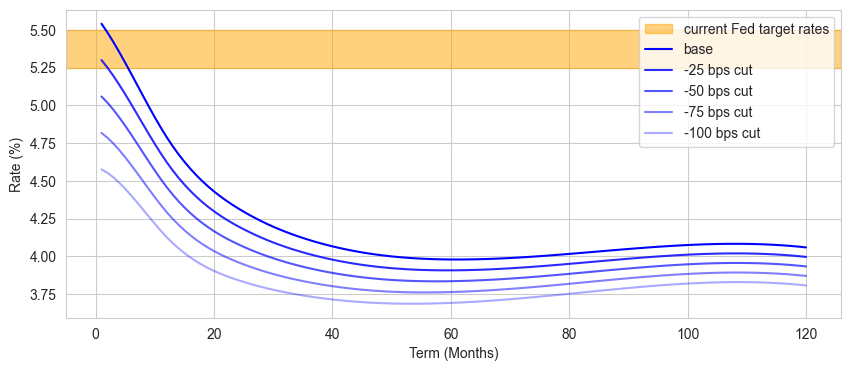

In [25]:
econ_scenarios = pd.DataFrame(spot_curve.rename(0))

for _cuts in range(-25, -101, -25):
    econ_scenarios[_cuts] = econ_scenarios[0] + (_cuts / 10**4) * (
        np.exp(-econ_scenarios.index / 20) * (3 / 4) + 1 / 4
    )


fig_rate_cuts, ax = plt.subplots(figsize=(10, 4))
ax.axhspan(
    ymin=5.25, ymax=5.50, label="current Fed target rates", alpha=0.5, color="orange"
)

for _s in econ_scenarios.columns:
    ax.plot(
        econ_scenarios[_s] * 100,
        label="base" if _s == 0 else "{:d} bps cut".format(_s),
        color="blue",
        alpha=1 - (int(_s) / -150),
    )

ax.set_xlabel("Term (Months)")
ax.set_ylabel("Rate (%)")
ax.legend(loc="upper right")

In [26]:
rate_cut_prices_175 = pd.Series()
rate_cut_prices_400 = pd.Series()



for _s in econ_scenarios.columns:

    _spot_curve = econ_scenarios[_s]

    rate_cut_prices_175.loc[_s] = get_fixed_rate_bond_price(

        _spot_curve, maturity_date=60, coupon_rate=1.75, next_payment=6

    )
    rate_cut_prices_400.loc[_s] = get_fixed_rate_bond_price(
        _spot_curve, maturity_date=60, coupon_rate=4, next_payment=6
    )


for _s in econ_scenarios.columns:

    print(
        "With {:d} bps rate cut, the prices of 1.75s of 1/31/2029 and 4s of 1/31/2029 are {:0.4f} and {:0.4f}.".format(
            abs(_s), rate_cut_prices_175.loc[_s], rate_cut_prices_400.loc[_s]
        )
    )

With 0 bps rate cut, the prices of 1.75s of 1/31/2029 and 4s of 1/31/2029 are 89.7765 and 99.8327.
With 25 bps rate cut, the prices of 1.75s of 1/31/2029 and 4s of 1/31/2029 are 90.0912 and 100.1728.
With 50 bps rate cut, the prices of 1.75s of 1/31/2029 and 4s of 1/31/2029 are 90.4070 and 100.5141.
With 75 bps rate cut, the prices of 1.75s of 1/31/2029 and 4s of 1/31/2029 are 90.7239 and 100.8566.
With 100 bps rate cut, the prices of 1.75s of 1/31/2029 and 4s of 1/31/2029 are 91.0419 and 101.2003.
